In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from sklearn.linear_model import LinearRegression

# Read in data

## Measurements and CAN Messages

The data in ```left_distance_381.csv``` contains a set of measurements and recorded CAN messages. The measurements represent how far a person was standing from the back car radar. While the person was standing there, the distance was measured, and the message was recorded. The values are matched temporally. It is assumed to be known that the radar messages are present in message ID 381.

In [2]:
csv = pd.read_csv(r"data\left_distance_381.csv")

In [3]:
csv

,Clock,MessageID,Message,Physical Distance
0,2025-08-27 16:49:35.059258938,381,c665e00319fe7250624c00481fdfc940cbb05c03165ffd...,6.117902
1,2025-08-27 16:49:35.959311008,381,0c46f2031a01f64a5ee400482012c940cbb05c03165ffd...,6.117902
2,2025-08-27 16:49:36.067419052,381,e17df4031a025a505f7400476012c940cbb05c03165ffd...,6.117902
3,2025-08-27 16:49:37.759351015,381,9c7d16031a0ce65c5d340046a013c940cbb05c03165ffd...,6.117902
4,2025-08-27 16:50:24.509124994,381,3f6eb7031fe3d268612c00475fecc940cdafcc03165ffd...,6.117902
...,...,...,...,...
1615,2025-08-27 17:17:58.411001921,381,993bae04318b3a7bbe9400731ffdc900cdaeac03165ffd...,8.250000
1616,2025-08-27 17:17:58.911154032,381,e248b80432314d75bdfc00731ffec900cdaf3c03165ffd...,8.250000
1617,2025-08-27 17:17:59.359239101,381,4b64c10432331065bc4c00725fd2c900cdaf3c03165ffd...,8.250000
1618,2025-08-27 17:17:59.458843946,381,4651c3043233745fbe940071dfdcc9406dbf2400729fec...,8.250000


In [4]:
# Translate hex message to binary
csv["Binary"] = csv["Message"].apply(lambda hex_input: np.array([float(x) for x in list(format(int(hex_input, 16), '0512b'))]))
csv

,Clock,MessageID,Message,Physical Distance,Binary
0,2025-08-27 16:49:35.059258938,381,c665e00319fe7250624c00481fdfc940cbb05c03165ffd...,6.117902,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
1,2025-08-27 16:49:35.959311008,381,0c46f2031a01f64a5ee400482012c940cbb05c03165ffd...,6.117902,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
2,2025-08-27 16:49:36.067419052,381,e17df4031a025a505f7400476012c940cbb05c03165ffd...,6.117902,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,2025-08-27 16:49:37.759351015,381,9c7d16031a0ce65c5d340046a013c940cbb05c03165ffd...,6.117902,"[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
4,2025-08-27 16:50:24.509124994,381,3f6eb7031fe3d268612c00475fecc940cdafcc03165ffd...,6.117902,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
...,...,...,...,...,...
1615,2025-08-27 17:17:58.411001921,381,993bae04318b3a7bbe9400731ffdc900cdaeac03165ffd...,8.250000,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
1616,2025-08-27 17:17:58.911154032,381,e248b80432314d75bdfc00731ffec900cdaf3c03165ffd...,8.250000,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1617,2025-08-27 17:17:59.359239101,381,4b64c10432331065bc4c00725fd2c900cdaf3c03165ffd...,8.250000,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ..."
1618,2025-08-27 17:17:59.458843946,381,4651c3043233745fbe940071dfdcc9406dbf2400729fec...,8.250000,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."


## Full Stream of CAN Messages

The ```2025-08-27-16-11-56_JN8AT3CB9MW240939_CAN_Messages.csv``` file contains all the CAN messages recorded from the entire experiment. This includes driving to the parking lot, taking measurements, and then driving back. These messages are used to calculate the number of bit flips.

In [5]:
raw_csv = pd.read_csv(r"data\2025-08-27-16-11-56_JN8AT3CB9MW240939_CAN_Messages.csv")

# Calculate Bit Flips

In [6]:
def get_bit_flips(raw_can_df, message_id, message_length_bits):
    relevant_messages = raw_can_df[(raw_can_df["MessageID"] == message_id) & (raw_can_df["MessageLength"] == message_length_bits / 8)]

    number_of_bits = message_length_bits

    binary_messages = [bin(int('1'+m, 16))[3:] for m in relevant_messages['Message']]
    binary_array = np.array([list(m) for m in binary_messages], dtype=str)

    num_flips = np.zeros(number_of_bits, dtype=int)

    for i in range(len(binary_array) - 1):
        num_flips += (binary_array[i] != binary_array[i + 1]).astype(int)

    return num_flips

In [7]:
# Calculate bit flips for message 381, a 512-bit message
bit_flips = get_bit_flips(raw_csv, 381, 512)

# Bayesian Optimization

## Define Objective Function

In [8]:
def objective_function(x):
    df = csv.copy()
    
    # Translate start and length to integers
    start = max(0, min(math.floor(x[0]), len(df["Binary"].iloc[0]) - 1))
    length = max(1, min(math.floor(x[1]), len(df["Binary"].iloc[0]) - start))
    
    # Take subset of CAN messages using start and length
    df["Subset"] = df["Binary"].apply(lambda x: x[start: start + length])
    
    # Decode messages using start and length
    def decode_array(array):
        return sum(val * (2 ** (len(array) - i - 1)) for i, val in enumerate(array))
   
    df["Decoded"] = df["Subset"].apply(lambda arr: decode_array(arr))

    # Calculate correlation    
    corr = 0
    if df["Decoded"].std() == 0 or df["Physical Distance"].std() == 0:
        corr = 0
    else:
        corr = df["Decoded"].corr(df["Physical Distance"])
        if math.isnan(corr):
            corr = 0
    
    # Evaluate bit flips in window defined by start and length
    selected_bit_flips = bit_flips[start: start + length]
    
    # Count number of bits with zero flips
    num_zero_bits = sum([1 for bit in selected_bit_flips if bit == 0])
    
    # Count number of decreases between consecutive bits
    decreases = 0
    for i in range(len(selected_bit_flips) - 1):
        if selected_bit_flips[i] > selected_bit_flips[i + 1]:
            decreases += 1
    
    # Total loss function to minimize
    return 1 - corr + 0.1 * num_zero_bits + 0.1 * decreases

## Define Search Space

We bound the start to valid indices in a 512 bit message. Since we know the message we are looking for is continuous, we bound the length between 8 and 24 bits.

In [9]:
space = [Real(0.0, 511.0, name='start'),  # Continuous space for start
         Real(8.0, 24.0, name='length')]  # Continuous space for length

## Run Bayesian Optimization

In [10]:
# Perform Bayesian Optimization
result = gp_minimize(objective_function,      # The function to minimize
                     space,                   # The search space
                     n_calls=200,             # The number of evaluations
                     random_state=42)         # Random state for reproducibility

c:\Users\sanborkl\AppData\Local\anaconda3\envs\strym\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 8.0] before, using random point [127.0434190541617, 11.519102568289085]
  warnings.warn(
c:\Users\sanborkl\AppData\Local\anaconda3\envs\strym\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 8.0] before, using random point [132.4781997773528, 10.74815785056366]
  warnings.warn(


## Plot Bayesian Optimization Convergence

In [11]:
convergence_vals = []

for i in range(200):
    prev_max = min(convergence_vals) if len(convergence_vals) > 0 else 1000
    convergence_vals.append(min(prev_max, result["func_vals"][i]))

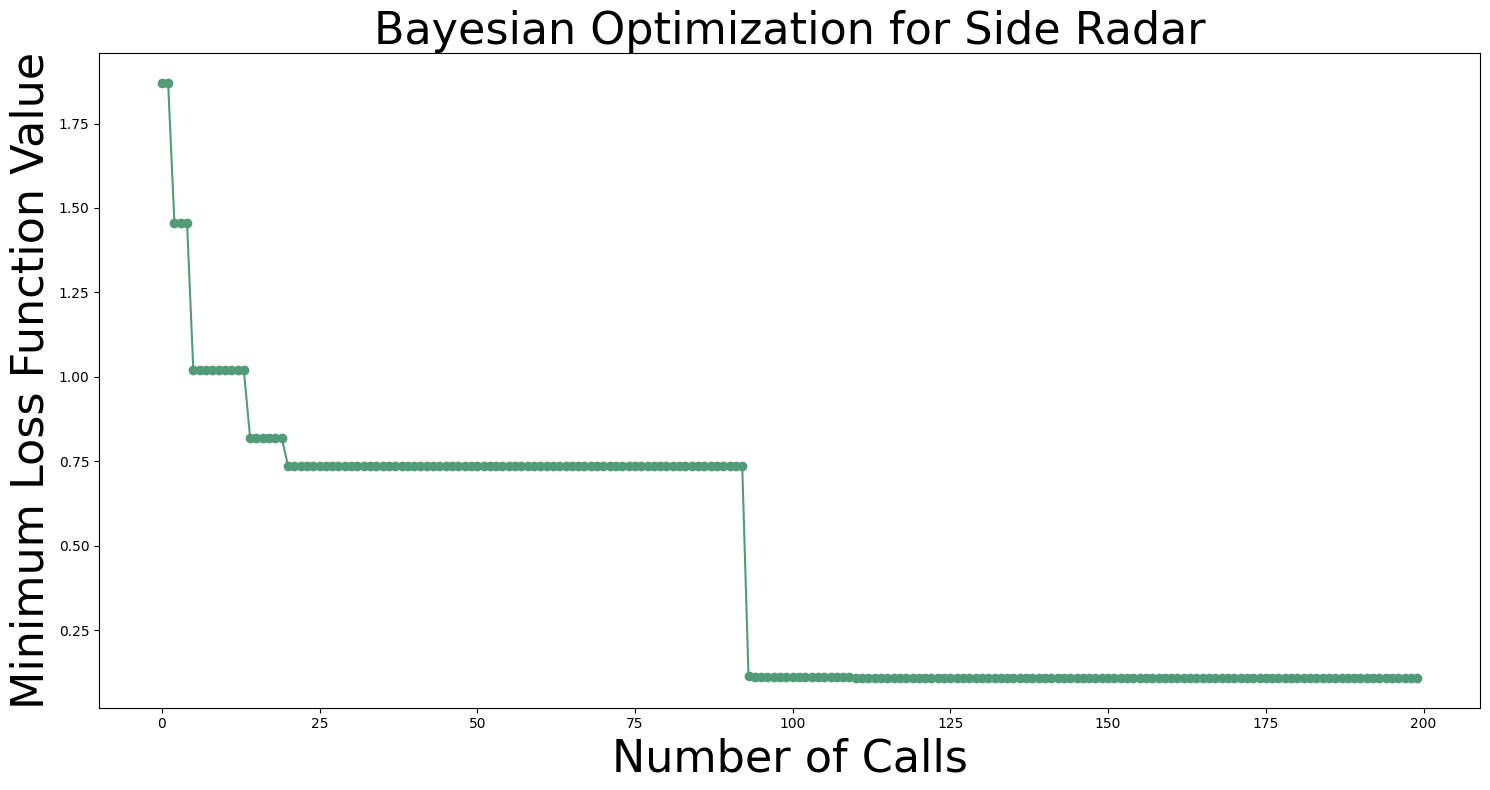

In [12]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1,1,1)

ax.plot(list(range(200)), convergence_vals, color="#529b79")
ax.scatter(list(range(200)), convergence_vals, color="#529b79")

ax.set_xlabel("Number of Calls", fontsize=32)
ax.set_ylabel("Minimum Loss Function Value", fontsize=32)
ax.set_title("Bayesian Optimization for Side Radar", fontsize=32)

fig.show(warn=False)
plt.tight_layout()


## Collect Candidate Points

Here, we collect all the start and length pairs that have a loss function value very close to the minimum loss value.

In [13]:
index = abs(result["func_vals"] - min(result["func_vals"])) < 0.01

filtered_list_comprehension = [item for item, condition in zip(result["x_iters"], index) if condition]

# Linear Regression

## Decode CAN Messages using Predicted Start and Length

In [14]:
def decode_df(df, start, length):
    df["Subset"] = df["Binary"].apply(lambda x: x[start: start + length])
    
    def decode_array(array):
        return sum(val * (2 ** (len(array) - i - 1)) for i, val in enumerate(array))

    
    df["Decoded Final"] = df["Subset"].apply(lambda arr: decode_array(arr))
    
    return df

## Find start and length pair with minimum offset

We run linear regression on all candidate pairs and determine the pair that achieves the lowest offset.

In [15]:
min_offset = 100

best_start = None
best_length = None
best_scale = None
best_offset = None

for start, length in filtered_list_comprehension:
    my_start = math.floor(start)
    my_length = math.floor(length)
    decoded_df = decode_df(csv.copy(), my_start, my_length)
    reg = LinearRegression().fit(decoded_df["Decoded Final"].to_numpy().reshape(-1, 1), decoded_df["Physical Distance"].to_numpy())
    min_offset = min(min_offset, reg.intercept_)
    if (reg.intercept_ == min_offset):
        best_start = my_start
        best_length = my_length
        best_scale = reg.coef_[0]

## Identify scale and offset from ideal start and length parameters

In [16]:
start = math.floor(best_start)
length = math.floor(best_length)
print(f"Best start: {best_start}")
print(f"Best length: {best_length}")

Best start: 88
Best length: 9


In [17]:
final_decoded_df = decode_df(csv.copy(), start, length)
final_reg = LinearRegression().fit(final_decoded_df["Decoded Final"].to_numpy().reshape(-1, 1), final_decoded_df["Physical Distance"].to_numpy())

In [18]:
scale = final_reg.coef_[0]
offset = final_reg.intercept_
print(f"Best scale: {scale:.3f}")
print(f"Best offset: {offset:.3f}")

Best scale: 0.033
Best offset: 0.587


## Calculate final regression score and plot results

In [19]:
score = final_reg.score(final_decoded_df["Decoded Final"].to_numpy().reshape(-1, 1), final_decoded_df["Physical Distance"].to_numpy())
print(f"Coefficient of determination: {score:.3f}")

Coefficient of determination: 0.980


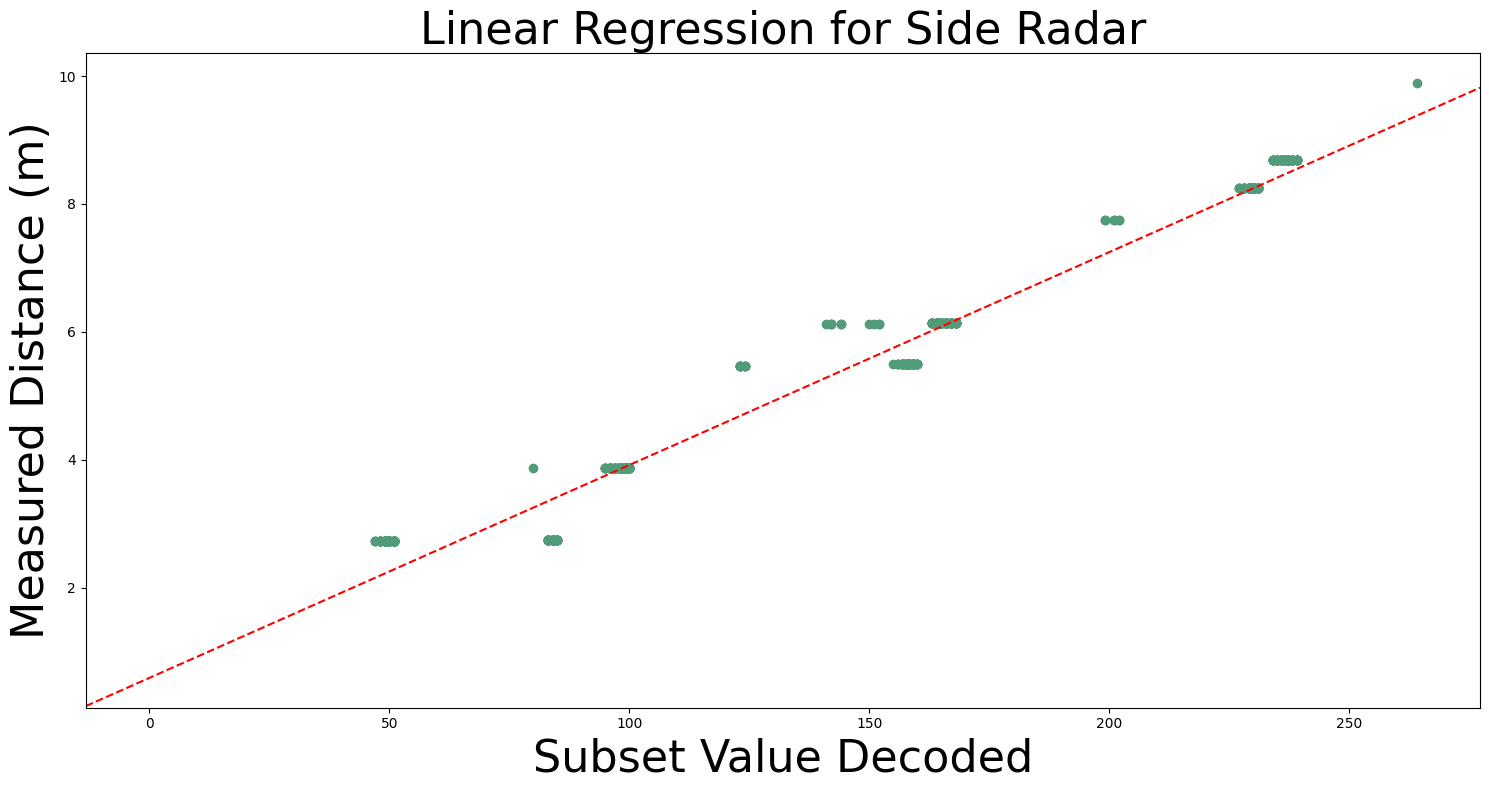

In [20]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1,1,1)

ax.axline((0, final_reg.intercept_), slope=final_reg.coef_[0], color='red', linestyle='--')
ax.scatter(final_decoded_df["Decoded Final"], final_decoded_df["Physical Distance"], color="#529b79")


ax.set_xlabel("Subset Value Decoded", fontsize=32)
ax.set_ylabel("Measured Distance (m)", fontsize=32)
ax.set_title("Linear Regression for Side Radar", fontsize=32)

fig.show(warn=False)
plt.tight_layout()
